**CLONING REPO FROM GITHUB**

In [1]:
%cd /content/
!git clone https://github.com/noe77778/Rodinia_noe

/content
Cloning into 'Rodinia_noe'...
remote: Enumerating objects: 2128, done.
remote: Counting objects: 100% (2128/2128), done.
remote: Compressing objects: 100% (1039/1039), done.
remote: Total 2128 (delta 1023), reused 2056 (delta 991), pack-reused 0
Receiving objects: 100% (2128/2128), 41.44 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (1023/1023), done.


In [2]:
%cd /content/Rodinia_noe/cuda/nn

/content/Rodinia_noe/cuda/nn


**Execute original datatype with float**

In [12]:
%%writefile float_DT.cu
/*
 * nn.cu
 * Nearest Neighbor
 *
 */

#include <stdio.h>
#include <sys/time.h>
#include <vector>
#include "cuda.h"

#define min( a, b )        a > b ? b : a
#define ceilDiv( a, b )    ( a + b - 1 ) / b
#define print( x )         printf( #x ": %lu\n", (unsigned long) x )
#define DEBUG           false

#define DEFAULT_THREADS_PER_BLOCK 256

#define MAX_ARGS 10
#define REC_LENGTH 53 // size of a record in db
#define LATITUDE_POS 28 // character position of the latitude value in each record
#define OPEN 10000   // initial value of nearest neighbors
#define Datatype float

typedef struct latLong
{
  Datatype lat;
  Datatype lng;
} LatLong;

typedef struct record
{
  char recString[REC_LENGTH];
  Datatype distance;
} Record;

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations);
void findLowest(std::vector<Record> &records,Datatype *distances,int numRecords,int topN);
void printUsage();
int parseCommandline(int argc, char *argv[], char* filename,int *r,Datatype *lat,Datatype *lng,
                     int *q, int *t, int *p, int *d);

/**
* Kernel
* Executed on GPU
* Calculates the Euclidean distance from each record in the database to the target position
*/
__global__ void euclid(LatLong *d_locations, Datatype *d_distances, int numRecords,Datatype lat, Datatype lng)
{
   //int globalId = gridDim.x * blockDim.x * blockIdx.y + blockDim.x * blockIdx.x + threadIdx.x;
   int globalId = blockDim.x * ( gridDim.x * blockIdx.y + blockIdx.x ) + threadIdx.x; // more efficient
    LatLong *latLong = d_locations+globalId;
    if (globalId < numRecords) {
        Datatype *dist=d_distances+globalId;
        *dist = (Datatype)sqrt((lat-latLong->lat)*(lat-latLong->lat)+(lng-latLong->lng)*(lng-latLong->lng));
   }
}

/**
* This program finds the k-nearest neighbors
**/

int main(int argc, char* argv[])
{
   int    i=0;
   Datatype lat, lng;
   int quiet=0,timing=0,platform=0,device=0;

    std::vector<Record> records;
   std::vector<LatLong> locations;
   char filename[100];
   int resultsCount=10;

    // parse command line
    if (parseCommandline(argc, argv, filename,&resultsCount,&lat,&lng,
                     &quiet, &timing, &platform, &device)) {
      printUsage();
      return 0;
    }

    int numRecords = loadData(filename,records,locations);
    if (resultsCount > numRecords) resultsCount = numRecords;

    //for(i=0;i<numRecords;i++)
    //  printf("%s, %f, %f\n",(records[i].recString),locations[i].lat,locations[i].lng);


    //Pointers to host memory
   Datatype *distances;
   //Pointers to device memory
   LatLong *d_locations;
   Datatype *d_distances;


   // Scaling calculations - added by Sam Kauffman
   cudaDeviceProp deviceProp;
   cudaGetDeviceProperties( &deviceProp, 0 );
   cudaThreadSynchronize();
   unsigned long maxGridX = deviceProp.maxGridSize[0];
   unsigned long threadsPerBlock = min( deviceProp.maxThreadsPerBlock, DEFAULT_THREADS_PER_BLOCK );
   size_t totalDeviceMemory;
   size_t freeDeviceMemory;
   cudaMemGetInfo(  &freeDeviceMemory, &totalDeviceMemory );
   cudaThreadSynchronize();
   unsigned long usableDeviceMemory = freeDeviceMemory * 85 / 100; // 85% arbitrary throttle to compensate for known CUDA bug
   unsigned long maxThreads = usableDeviceMemory / 12; // 4 bytes in 3 vectors per thread
   if ( numRecords > maxThreads )
   {
      fprintf( stderr, "Error: Input too large.\n" );
      exit( 1 );
   }
   unsigned long blocks = ceilDiv( numRecords, threadsPerBlock ); // extra threads will do nothing
   unsigned long gridY = ceilDiv( blocks, maxGridX );
   unsigned long gridX = ceilDiv( blocks, gridY );
   // There will be no more than (gridY - 1) extra blocks
   dim3 gridDim( gridX, gridY );

   if ( DEBUG )
   {
      print( totalDeviceMemory ); // 804454400
      print( freeDeviceMemory );
      print( usableDeviceMemory );
      print( maxGridX ); // 65535
      print( deviceProp.maxThreadsPerBlock ); // 1024
      print( threadsPerBlock );
      print( maxThreads );
      print( blocks ); // 130933
      print( gridY );
      print( gridX );
   }

   /**
   * Allocate memory on host and device
   */
   distances = (Datatype *)malloc(sizeof(Datatype) * numRecords);
   cudaMalloc((void **) &d_locations,sizeof(LatLong) * numRecords);
   cudaMalloc((void **) &d_distances,sizeof(Datatype) * numRecords);

   /**
    * Transfer data from host to device
    */
    struct timeval h2dstart, h2dstop;
    float h2dtime;
    gettimeofday(&h2dstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    cudaMemcpy( d_locations, &locations[0], sizeof(LatLong) * numRecords, cudaMemcpyHostToDevice);
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&h2dstop,NULL);
    h2dtime = (h2dstop.tv_usec-h2dstart.tv_usec)*1.0e-6 + h2dstop.tv_sec - h2dstart.tv_sec;
    printf("H2D Time: %.7f (s)\n",h2dtime);

    /**
    * Execute kernel
    */
    struct timeval kernelstart, kernelstop;
    float kerneltime;
    gettimeofday(&kernelstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    euclid<<< gridDim, threadsPerBlock >>>(d_locations,d_distances,numRecords,lat,lng);
    cudaThreadSynchronize();
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&kernelstop,NULL);
    kerneltime = (kernelstop.tv_usec-kernelstart.tv_usec)*1.0e-6 + kernelstop.tv_sec - kernelstart.tv_sec;
    printf("Kernel Time: %.7f (s)\n",kerneltime);

    //Copy data from device memory to host memory
    struct timeval d2hstart, d2hstop;
    float d2htime;
    gettimeofday(&d2hstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    cudaMemcpy( distances, d_distances, sizeof(Datatype)*numRecords, cudaMemcpyDeviceToHost );
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&d2hstop,NULL);
    d2htime = (d2hstop.tv_usec-d2hstart.tv_usec)*1.0e-6 + d2hstop.tv_sec - d2hstart.tv_sec;
    printf("D2H Time: %.7f (s)\n",d2htime);

   // find the resultsCount least distances
    findLowest(records,distances,numRecords,resultsCount);

    // print out results
    if (!quiet)
    for(i=0;i<10;i++) { //for(i=0;i<resultsCount;i++)
      printf("%s --> Distance=%f\n",records[i].recString,records[i].distance);
    }
    free(distances);
    //Free memory
   cudaFree(d_locations);
   cudaFree(d_distances);

}

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations){
    FILE   *flist,*fp;
   int    i=0;
   char dbname[64];
   int recNum=0;

    /**Main processing **/

    flist = fopen(filename, "r");
   while(!feof(flist)) {
      /**
      * Read in all records of length REC_LENGTH
      * If this is the last file in the filelist, then done
      * else open next file to be read next iteration
      */
      if(fscanf(flist, "%s\n", dbname) != 1) {
            fprintf(stderr, "error reading filelist\n");
            exit(0);
        }
        fp = fopen(dbname, "r");
        if(!fp) {
            printf("error opening a db\n");
            exit(1);
        }
        // read each record
        while(!feof(fp)){
            Record record;
            LatLong latLong;
            fgets(record.recString,49,fp);
            fgetc(fp); // newline
            if (feof(fp)) break;

            // parse for lat and long
            char substr[6];

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+28);
            substr[5] = '\0';
            latLong.lat = atof(substr);

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+33);
            substr[5] = '\0';
            latLong.lng = atof(substr);

            locations.push_back(latLong);
            records.push_back(record);
            recNum++;
        }
        fclose(fp);
    }
    fclose(flist);
//    for(i=0;i<rec_count*REC_LENGTH;i++) printf("%c",sandbox[i]);
    return recNum;
}

void findLowest(std::vector<Record> &records,Datatype *distances,int numRecords,int topN){
  int i,j;
  Datatype val;
  int minLoc;
  Record *tempRec;
  Datatype tempDist;

  for(i=0;i<topN;i++) {
    minLoc = i;
    for(j=i;j<numRecords;j++) {
      val = distances[j];
      if (val < distances[minLoc]) minLoc = j;
    }
    // swap locations and distances
    tempRec = &records[i];
    records[i] = records[minLoc];
    records[minLoc] = *tempRec;

    tempDist = distances[i];
    distances[i] = distances[minLoc];
    distances[minLoc] = tempDist;

    // add distance to the min we just found
    records[i].distance = distances[i];
  }
}

int parseCommandline(int argc, char *argv[], char* filename,int *r,Datatype *lat,Datatype *lng,
                     int *q, int *t, int *p, int *d){
    int i;
    if (argc < 2) return 1; // error
    strncpy(filename,argv[1],100);
    char flag;

    for(i=1;i<argc;i++) {
      if (argv[i][0]=='-') {// flag
        flag = argv[i][1];
          switch (flag) {
            case 'r': // number of results
              i++;
              *r = atoi(argv[i]);
              break;
            case 'l': // lat or lng
              if (argv[i][2]=='a') {//lat
                *lat = atof(argv[i+1]);
              }
              else {//lng
                *lng = atof(argv[i+1]);
              }
              i++;
              break;
            case 'h': // help
              return 1;
            case 'q': // quiet
              *q = 1;
              break;
            case 't': // timing
              *t = 1;
              break;
            case 'p': // platform
              i++;
              *p = atoi(argv[i]);
              break;
            case 'd': // device
              i++;
              *d = atoi(argv[i]);
              break;
        }
      }
    }
    if ((*d >= 0 && *p<0) || (*p>=0 && *d<0)) // both p and d must be specified if either are specified
      return 1;
    return 0;
}

void printUsage(){
  printf("Nearest Neighbor Usage\n");
  printf("\n");
  printf("nearestNeighbor [filename] -r [int] -lat [Datatype] -lng [Datatype] [-hqt] [-p [int] -d [int]]\n");
  printf("\n");
  printf("example:\n");
  printf("$ ./nearestNeighbor filelist.txt -r 5 -lat 30 -lng 90\n");
  printf("\n");
  printf("filename     the filename that lists the data input files\n");
  printf("-r [int]     the number of records to return (default: 10)\n");
  printf("-lat [Datatype] the latitude for nearest neighbors (default: 0)\n");
  printf("-lng [Datatype] the longitude for nearest neighbors (default: 0)\n");
  printf("\n");
  printf("-h, --help   Display the help file\n");
  printf("-q           Quiet mode. Suppress all text output.\n");
  printf("-t           Print timing information.\n");
  printf("\n");
  printf("-p [int]     Choose the platform (must choose both platform and device)\n");
  printf("-d [int]     Choose the device (must choose both platform and device)\n");
  printf("\n");
  printf("\n");
  printf("Notes: 1. The filename is required as the first parameter.\n");
  printf("       2. If you declare either the device or the platform,\n");
  printf("          you must declare both.\n\n");
}


Overwriting float_DT.cu


In [13]:
!nvcc -arch=sm_75 float_DT.cu -o float_DT

float_DT.cu: In function ‘int main(int, char**)’:
float_DT.cu:98:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
    cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
float_DT.cu:104:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
    cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
float_DT.cu:160:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
     cud

Change number of returned records

In [15]:
%%shell 
#!/bin/bash
PARA="r"
BOARDER="+++++++++++++++++++++++++++++++++++"
for FILE_NAME in "filelist_4"
do
  for VARIABLE in 5 500 50000 500000
  do
      echo $BOARDER $FILE_NAME $PARA $VARIABLE $BOARDER
      nvprof ./float_DT $FILE_NAME -r $VARIABLE -lat 30 -lng 90
  done
done

+++++++++++++++++++++++++++++++++++ filelist_4 r 5 +++++++++++++++++++++++++++++++++++
==2427== NVPROF is profiling process 2427, command: ./float_DT filelist_4 -r 5 -lat 30 -lng 90
Time: 0.0000961 (s)
Time: 0.0000501 (s)
Time: 0.0000911 (s)
1988 12 27  0 18 TONY       30.0  89.8  113   39 --> Distance=0.199997
1980 10 22 18  3 ISAAC      30.1  90.4  110  778 --> Distance=0.412312
1997 11 14 12 24 HELENE     30.5  89.8  134  529 --> Distance=0.538515
2003  8 27 12 10 TONY       29.9  89.4  160  286 --> Distance=0.608275
1974 12 22 18 24 JOYCE      30.6  89.9   80  593 --> Distance=0.608276
1962  8 24 12 10 GORDON     48.1 145.3   10  670 --> Distance=-909169759238956819415040.000000
1999  3  9 12 24 KIRK       52.7 335.6   98  219 --> Distance=-909169759238956819415040.000000
1998  9 23  0  6 WILLIAM    47.3 237.4  120  878 --> Distance=-909169759238956819415040.000000
1980 11  6 12 18 SANDY      15.8  84.2  153   47 --> Distance=-909169759238956819415040.000000
1951  1 17 12 17 SANDY 

**Execute datatype as double**

In [19]:
%%writefile double_DT.cu
/*
 * nn.cu
 * Nearest Neighbor
 *
 */

#include <stdio.h>
#include <sys/time.h>
#include <vector>
#include "cuda.h"

#define min( a, b )        a > b ? b : a
#define ceilDiv( a, b )    ( a + b - 1 ) / b
#define print( x )         printf( #x ": %lu\n", (unsigned long) x )
#define DEBUG           false

#define DEFAULT_THREADS_PER_BLOCK 256

#define MAX_ARGS 10
#define REC_LENGTH 53 // size of a record in db
#define LATITUDE_POS 28 // character position of the latitude value in each record
#define OPEN 10000   // initial value of nearest neighbors
#define Datatype double

typedef struct latLong
{
  Datatype lat;
  Datatype lng;
} LatLong;

typedef struct record
{
  char recString[REC_LENGTH];
  Datatype distance;
} Record;

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations);
void findLowest(std::vector<Record> &records,Datatype *distances,int numRecords,int topN);
void printUsage();
int parseCommandline(int argc, char *argv[], char* filename,int *r,Datatype *lat,Datatype *lng,
                     int *q, int *t, int *p, int *d);

/**
* Kernel
* Executed on GPU
* Calculates the Euclidean distance from each record in the database to the target position
*/
__global__ void euclid(LatLong *d_locations, Datatype *d_distances, int numRecords,Datatype lat, Datatype lng)
{
   //int globalId = gridDim.x * blockDim.x * blockIdx.y + blockDim.x * blockIdx.x + threadIdx.x;
   int globalId = blockDim.x * ( gridDim.x * blockIdx.y + blockIdx.x ) + threadIdx.x; // more efficient
    LatLong *latLong = d_locations+globalId;
    if (globalId < numRecords) {
        Datatype *dist=d_distances+globalId;
        *dist = (Datatype)sqrt((lat-latLong->lat)*(lat-latLong->lat)+(lng-latLong->lng)*(lng-latLong->lng));
   }
}

/**
* This program finds the k-nearest neighbors
**/

int main(int argc, char* argv[])
{
   int    i=0;
   Datatype lat, lng;
   int quiet=0,timing=0,platform=0,device=0;

    std::vector<Record> records;
   std::vector<LatLong> locations;
   char filename[100];
   int resultsCount=10;

    // parse command line
    if (parseCommandline(argc, argv, filename,&resultsCount,&lat,&lng,
                     &quiet, &timing, &platform, &device)) {
      printUsage();
      return 0;
    }

    int numRecords = loadData(filename,records,locations);
    if (resultsCount > numRecords) resultsCount = numRecords;

    //for(i=0;i<numRecords;i++)
    //  printf("%s, %f, %f\n",(records[i].recString),locations[i].lat,locations[i].lng);


    //Pointers to host memory
   Datatype *distances;
   //Pointers to device memory
   LatLong *d_locations;
   Datatype *d_distances;


   // Scaling calculations - added by Sam Kauffman
   cudaDeviceProp deviceProp;
   cudaGetDeviceProperties( &deviceProp, 0 );
   cudaThreadSynchronize();
   unsigned long maxGridX = deviceProp.maxGridSize[0];
   unsigned long threadsPerBlock = min( deviceProp.maxThreadsPerBlock, DEFAULT_THREADS_PER_BLOCK );
   size_t totalDeviceMemory;
   size_t freeDeviceMemory;
   cudaMemGetInfo(  &freeDeviceMemory, &totalDeviceMemory );
   cudaThreadSynchronize();
   unsigned long usableDeviceMemory = freeDeviceMemory * 85 / 100; // 85% arbitrary throttle to compensate for known CUDA bug
   unsigned long maxThreads = usableDeviceMemory / 12; // 4 bytes in 3 vectors per thread
   if ( numRecords > maxThreads )
   {
      fprintf( stderr, "Error: Input too large.\n" );
      exit( 1 );
   }
   unsigned long blocks = ceilDiv( numRecords, threadsPerBlock ); // extra threads will do nothing
   unsigned long gridY = ceilDiv( blocks, maxGridX );
   unsigned long gridX = ceilDiv( blocks, gridY );
   // There will be no more than (gridY - 1) extra blocks
   dim3 gridDim( gridX, gridY );

   if ( DEBUG )
   {
      print( totalDeviceMemory ); // 804454400
      print( freeDeviceMemory );
      print( usableDeviceMemory );
      print( maxGridX ); // 65535
      print( deviceProp.maxThreadsPerBlock ); // 1024
      print( threadsPerBlock );
      print( maxThreads );
      print( blocks ); // 130933
      print( gridY );
      print( gridX );
   }

   /**
   * Allocate memory on host and device
   */
   distances = (Datatype *)malloc(sizeof(Datatype) * numRecords);
   cudaMalloc((void **) &d_locations,sizeof(LatLong) * numRecords);
   cudaMalloc((void **) &d_distances,sizeof(Datatype) * numRecords);

   /**
    * Transfer data from host to device
    */
    struct timeval h2dstart, h2dstop;
    float h2dtime;
    gettimeofday(&h2dstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    cudaMemcpy( d_locations, &locations[0], sizeof(LatLong) * numRecords, cudaMemcpyHostToDevice);
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&h2dstop,NULL);
    h2dtime = (h2dstop.tv_usec-h2dstart.tv_usec)*1.0e-6 + h2dstop.tv_sec - h2dstart.tv_sec;
    printf("H2D Time: %.7f (s)\n",h2dtime);

    /**
    * Execute kernel
    */
    struct timeval kernelstart, kernelstop;
    float kerneltime;
    gettimeofday(&kernelstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    euclid<<< gridDim, threadsPerBlock >>>(d_locations,d_distances,numRecords,lat,lng);
    cudaThreadSynchronize();
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&kernelstop,NULL);
    kerneltime = (kernelstop.tv_usec-kernelstart.tv_usec)*1.0e-6 + kernelstop.tv_sec - kernelstart.tv_sec;
    printf("Kernel Time: %.7f (s)\n",kerneltime);

    //Copy data from device memory to host memory
    struct timeval d2hstart, d2hstop;
    float d2htime;
    gettimeofday(&d2hstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    cudaMemcpy( distances, d_distances, sizeof(Datatype)*numRecords, cudaMemcpyDeviceToHost );
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&d2hstop,NULL);
    d2htime = (d2hstop.tv_usec-d2hstart.tv_usec)*1.0e-6 + d2hstop.tv_sec - d2hstart.tv_sec;
    printf("D2H Time: %.7f (s)\n",d2htime);

   // find the resultsCount least distances
    findLowest(records,distances,numRecords,resultsCount);

    // print out results
    if (!quiet)
    for(i=0;i<10;i++) { //for(i=0;i<resultsCount;i++)
      printf("%s --> Distance=%f\n",records[i].recString,records[i].distance);
    }
    free(distances);
    //Free memory
   cudaFree(d_locations);
   cudaFree(d_distances);

}

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations){
    FILE   *flist,*fp;
   int    i=0;
   char dbname[64];
   int recNum=0;

    /**Main processing **/

    flist = fopen(filename, "r");
   while(!feof(flist)) {
      /**
      * Read in all records of length REC_LENGTH
      * If this is the last file in the filelist, then done
      * else open next file to be read next iteration
      */
      if(fscanf(flist, "%s\n", dbname) != 1) {
            fprintf(stderr, "error reading filelist\n");
            exit(0);
        }
        fp = fopen(dbname, "r");
        if(!fp) {
            printf("error opening a db\n");
            exit(1);
        }
        // read each record
        while(!feof(fp)){
            Record record;
            LatLong latLong;
            fgets(record.recString,49,fp);
            fgetc(fp); // newline
            if (feof(fp)) break;

            // parse for lat and long
            char substr[6];

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+28);
            substr[5] = '\0';
            latLong.lat = atof(substr);

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+33);
            substr[5] = '\0';
            latLong.lng = atof(substr);

            locations.push_back(latLong);
            records.push_back(record);
            recNum++;
        }
        fclose(fp);
    }
    fclose(flist);
//    for(i=0;i<rec_count*REC_LENGTH;i++) printf("%c",sandbox[i]);
    return recNum;
}

void findLowest(std::vector<Record> &records,Datatype *distances,int numRecords,int topN){
  int i,j;
  Datatype val;
  int minLoc;
  Record *tempRec;
  Datatype tempDist;

  for(i=0;i<topN;i++) {
    minLoc = i;
    for(j=i;j<numRecords;j++) {
      val = distances[j];
      if (val < distances[minLoc]) minLoc = j;
    }
    // swap locations and distances
    tempRec = &records[i];
    records[i] = records[minLoc];
    records[minLoc] = *tempRec;

    tempDist = distances[i];
    distances[i] = distances[minLoc];
    distances[minLoc] = tempDist;

    // add distance to the min we just found
    records[i].distance = distances[i];
  }
}

int parseCommandline(int argc, char *argv[], char* filename,int *r,Datatype *lat,Datatype *lng,
                     int *q, int *t, int *p, int *d){
    int i;
    if (argc < 2) return 1; // error
    strncpy(filename,argv[1],100);
    char flag;

    for(i=1;i<argc;i++) {
      if (argv[i][0]=='-') {// flag
        flag = argv[i][1];
          switch (flag) {
            case 'r': // number of results
              i++;
              *r = atoi(argv[i]);
              break;
            case 'l': // lat or lng
              if (argv[i][2]=='a') {//lat
                *lat = atof(argv[i+1]);
              }
              else {//lng
                *lng = atof(argv[i+1]);
              }
              i++;
              break;
            case 'h': // help
              return 1;
            case 'q': // quiet
              *q = 1;
              break;
            case 't': // timing
              *t = 1;
              break;
            case 'p': // platform
              i++;
              *p = atoi(argv[i]);
              break;
            case 'd': // device
              i++;
              *d = atoi(argv[i]);
              break;
        }
      }
    }
    if ((*d >= 0 && *p<0) || (*p>=0 && *d<0)) // both p and d must be specified if either are specified
      return 1;
    return 0;
}

void printUsage(){
  printf("Nearest Neighbor Usage\n");
  printf("\n");
  printf("nearestNeighbor [filename] -r [int] -lat [Datatype] -lng [Datatype] [-hqt] [-p [int] -d [int]]\n");
  printf("\n");
  printf("example:\n");
  printf("$ ./nearestNeighbor filelist.txt -r 5 -lat 30 -lng 90\n");
  printf("\n");
  printf("filename     the filename that lists the data input files\n");
  printf("-r [int]     the number of records to return (default: 10)\n");
  printf("-lat [Datatype] the latitude for nearest neighbors (default: 0)\n");
  printf("-lng [Datatype] the longitude for nearest neighbors (default: 0)\n");
  printf("\n");
  printf("-h, --help   Display the help file\n");
  printf("-q           Quiet mode. Suppress all text output.\n");
  printf("-t           Print timing information.\n");
  printf("\n");
  printf("-p [int]     Choose the platform (must choose both platform and device)\n");
  printf("-d [int]     Choose the device (must choose both platform and device)\n");
  printf("\n");
  printf("\n");
  printf("Notes: 1. The filename is required as the first parameter.\n");
  printf("       2. If you declare either the device or the platform,\n");
  printf("          you must declare both.\n\n");
}


Overwriting double_DT.cu


In [20]:
!nvcc -arch=sm_75 double_DT.cu -o double_DT

double_DT.cu: In function ‘int main(int, char**)’:
double_DT.cu:98:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
    cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
double_DT.cu:104:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
    cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
double_DT.cu:160:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
    

Change number of returned records

In [21]:
%%shell 
#!/bin/bash
PARA="r"
BOARDER="+++++++++++++++++++++++++++++++++++"
for FILE_NAME in "filelist_4"
do
  for VARIABLE in 5 500 50000 500000
  do
      echo $BOARDER $FILE_NAME $PARA $VARIABLE $BOARDER
      nvprof ./double_DT $FILE_NAME -r $VARIABLE -lat 30 -lng 90
  done
done

+++++++++++++++++++++++++++++++++++ filelist_4 r 5 +++++++++++++++++++++++++++++++++++
==3080== NVPROF is profiling process 3080, command: ./double_DT filelist_4 -r 5 -lat 30 -lng 90
Time: 0.0001800 (s)
Time: 0.0000780 (s)
Time: 0.0002680 (s)
1988 12 27  0 18 TONY       30.0  89.8  113   39 --> Distance=0.200000
1980 10 22 18  3 ISAAC      30.1  90.4  110  778 --> Distance=0.412311
1997 11 14 12 24 HELENE     30.5  89.8  134  529 --> Distance=0.538516
2003  8 27 12 10 TONY       29.9  89.4  160  286 --> Distance=0.608276
1974 12 22 18 24 JOYCE      30.6  89.9   80  593 --> Distance=0.608276
1962  8 24 12 10 GORDON     48.1 145.3   10  670 --> Distance=0.000000
1999  3  9 12 24 KIRK       52.7 335.6   98  219 --> Distance=0.000000
1998  9 23  0  6 WILLIAM    47.3 237.4  120  878 --> Distance=0.000000
1980 11  6 12 18 SANDY      15.8  84.2  153   47 --> Distance=0.000000
1951  1 17 12 17 SANDY      42.6 293.8   60  642 --> Distance=0.000000
==3080== Profiling application: ./double_DT fil

**Execute datatype as fp16 (__half)**

In [27]:
%%writefile half_DT.cu

#include <stdio.h>
#include <sys/time.h>
#include <float.h>
#include <vector>
#include "cuda.h"
#include <cuda_fp16.h>

#define min( a, b )     a > b ? b : a
#define ceilDiv( a, b )   ( a + b - 1 ) / b
#define print( x )      printf( #x ": %lu\n", (unsigned long) x )
#define DEBUG       false

#define DEFAULT_THREADS_PER_BLOCK 256

#define MAX_ARGS 10
#define REC_LENGTH 53 // size of a record in db
#define LATITUDE_POS 28 // character position of the latitude value in each record
#define OPEN 10000  // initial value of nearest neighbors
#define Datatype double

typedef struct latLong
{
  __half lat;
  __half lng;
} LatLong;

typedef struct record
{
  char recString[REC_LENGTH];
  __half distance;
} Record;

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations);
void findLowest(std::vector<Record> &records,__half *distances,int numRecords,int topN);
void printUsage();
int parseCommandline(int argc, char *argv[], char* filename,int *r,__half *lat,__half *lng,
                     int *q, int *t, int *p, int *d);

/**
* Kernel
* Executed on GPU
* Calculates the Euclidean distance from each record in the database to the target position
*/
__global__ void euclid(LatLong *d_locations, __half *d_distances, int numRecords, __half lat, __half lng)
{
  //int globalId = gridDim.x * blockDim.x * blockIdx.y + blockDim.x * blockIdx.x + threadIdx.x;
  int globalId = blockDim.x * ( gridDim.x * blockIdx.y + blockIdx.x ) + threadIdx.x; // more efficient
  LatLong *latLong = d_locations+globalId;
  if (globalId < numRecords) {
        __half *dist=d_distances+globalId;
        *dist = (__half)sqrt((Datatype)((lat-latLong->lat)*(lat-latLong->lat)+(lng-latLong->lng)*(lng-latLong->lng)));
  }
}

/**
* This program finds the k-nearest neighbors
**/

int main(int argc, char* argv[])
{
  int    i=0;
  __half lat, lng;
  int quiet=0,timing=0,platform=0,device=0;

  std::vector<Record> records;
  std::vector<LatLong> locations;
  char filename[100];
  int resultsCount=10;

  // parse command line
  if (parseCommandline(argc, argv, filename, &resultsCount, &lat, &lng,
                    &quiet, &timing, &platform, &device)) {
    printUsage();
    return 0;
  }

  int numRecords = loadData(filename,records,locations);
  if (resultsCount > numRecords) resultsCount = numRecords;

  //for(i=0;i<numRecords;i++)
  //  printf("%s, %f, %f\n",(records[i].recString),locations[i].lat,locations[i].lng);


  //Pointers to host memory
  __half *distances;
  //Pointers to device memory
  LatLong *d_locations;
  __half *d_distances;


  // Scaling calculations - added by Sam Kauffman
  cudaDeviceProp deviceProp;
  cudaGetDeviceProperties( &deviceProp, 0 );
  cudaThreadSynchronize();
  unsigned long maxGridX = deviceProp.maxGridSize[0];
  unsigned long threadsPerBlock = min( deviceProp.maxThreadsPerBlock, DEFAULT_THREADS_PER_BLOCK );
  size_t totalDeviceMemory;
  size_t freeDeviceMemory;
  cudaMemGetInfo(  &freeDeviceMemory, &totalDeviceMemory );
  cudaThreadSynchronize();
  unsigned long usableDeviceMemory = freeDeviceMemory * 85 / 100; // 85% arbitrary throttle to compensate for known CUDA bug
  unsigned long maxThreads = usableDeviceMemory / 12; // 4 bytes in 3 vectors per thread
  if ( numRecords > maxThreads )
  {
    fprintf( stderr, "Error: Input too large.\n" );
    exit( 1 );
  }
  unsigned long blocks = ceilDiv( numRecords, threadsPerBlock ); // extra threads will do nothing
  unsigned long gridY = ceilDiv( blocks, maxGridX );
  unsigned long gridX = ceilDiv( blocks, gridY );
  // There will be no more than (gridY - 1) extra blocks
  dim3 gridDim( gridX, gridY );

  if ( DEBUG )
  {
    print( totalDeviceMemory ); // 804454400
    print( freeDeviceMemory );
    print( usableDeviceMemory );
    print( maxGridX ); // 65535
    print( deviceProp.maxThreadsPerBlock ); // 1024
    print( threadsPerBlock );
    print( maxThreads );
    print( blocks ); // 130933
    print( gridY );
    print( gridX );
  }

  /**
  * Allocate memory on host and device
  */
  distances = (__half *)malloc(sizeof(__half) * numRecords);
  cudaMalloc((void **) &d_locations,sizeof(LatLong) * numRecords);
  cudaMalloc((void **) &d_distances,sizeof(__half) * numRecords);

   /**
    * Transfer data from host to device
    */
    struct timeval h2dstart, h2dstop;
    float h2dtime;
    gettimeofday(&h2dstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    cudaMemcpy( d_locations, &locations[0], sizeof(LatLong) * numRecords, cudaMemcpyHostToDevice);
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&h2dstop,NULL);
    h2dtime = (h2dstop.tv_usec-h2dstart.tv_usec)*1.0e-6 + h2dstop.tv_sec - h2dstart.tv_sec;
    printf("H2D Time: %.7f (s)\n",h2dtime);

    /**
    * Execute kernel
    */
    struct timeval kernelstart, kernelstop;
    float kerneltime;
    gettimeofday(&kernelstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    euclid<<< gridDim, threadsPerBlock >>>(d_locations,d_distances,numRecords,lat,lng);
    cudaThreadSynchronize();
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&kernelstop,NULL);
    kerneltime = (kernelstop.tv_usec-kernelstart.tv_usec)*1.0e-6 + kernelstop.tv_sec - kernelstart.tv_sec;
    printf("Kernel Time: %.7f (s)\n",kerneltime);

    //Copy data from device memory to host memory
    struct timeval d2hstart, d2hstop;
    float d2htime;
    gettimeofday(&d2hstart,NULL);
    ////////////////////////////////////////////////////////////////////////////////
    
    cudaMemcpy( distances, d_distances, sizeof(__half)*numRecords, cudaMemcpyDeviceToHost );
    ////////////////////////////////////////////////////////////////////////////////
    gettimeofday(&d2hstop,NULL);
    d2htime = (d2hstop.tv_usec-d2hstart.tv_usec)*1.0e-6 + d2hstop.tv_sec - d2hstart.tv_sec;
    printf("D2H Time: %.7f (s)\n",d2htime);

  // find the resultsCount least distances
    findLowest(records,distances,numRecords,resultsCount);

    // print out results
    if (!quiet)
    for(i=0;i<10;i++) {//for(i=0;i<resultsCount;i++)
      printf("%s --> Distance=%f\n",records[i].recString,(__half2float)(records[i].distance));
    }
    free(distances);
    //Free memory
  cudaFree(d_locations);
  cudaFree(d_distances);

}

int loadData(char *filename,std::vector<Record> &records,std::vector<LatLong> &locations){
    FILE   *flist,*fp;
    int    i=0;
    char dbname[64];
    int recNum=0;

    /**Main processing **/

    flist = fopen(filename, "r");
    while(!feof(flist)) {
    /**
    * Read in all records of length REC_LENGTH
    * If this is the last file in the filelist, then done
    * else open next file to be read next iteration
    */
        if(fscanf(flist, "%s\n", dbname) != 1) {
            fprintf(stderr, "error reading filelist\n");
            exit(0);
        }
        fp = fopen(dbname, "r");
        if(!fp) {
            printf("error opening a db\n");
            exit(1);
        }
        // read each record
        while(!feof(fp)){
            Record record;
            LatLong latLong;
            fgets(record.recString,49,fp);
            fgetc(fp); // newline
            if (feof(fp)) break;

            // parse for lat and long
            char substr[6];

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+28);
            substr[5] = '\0';
            latLong.lat = atof(substr);

            for(i=0;i<5;i++) substr[i] = *(record.recString+i+33);
            substr[5] = '\0';
            latLong.lng = atof(substr);

            locations.push_back(latLong);
            records.push_back(record);
            recNum++;
        }
        fclose(fp);
    }
    fclose(flist);
//    for(i=0;i<rec_count*REC_LENGTH;i++) printf("%c",sandbox[i]);
    return recNum;
}

void findLowest(std::vector<Record> &records,__half *distances,int numRecords,int topN){
  int i,j;
  __half val;
  int minLoc;
  Record *tempRec;
  __half tempDist;

  for(i=0;i<topN;i++) {
    minLoc = i;
    for(j=i;j<numRecords;j++) {
      val = distances[j];
      if ((__half2float)(val) < (__half2float)(distances[minLoc])) minLoc = j;
      //if (__hlt(val, distances[minLoc])) minLoc = j;
    }
    // swap locations and distances
    tempRec = &records[i];
    records[i] = records[minLoc];
    records[minLoc] = *tempRec;

    tempDist = distances[i];
    distances[i] = distances[minLoc];
    distances[minLoc] = tempDist;

    // add distance to the min we just found
    records[i].distance = distances[i];
  }
}

int parseCommandline(int argc, char *argv[], char* filename,int *r, __half *lat,__half *lng,
                     int *q, int *t, int *p, int *d){
    int i;
    if (argc < 2) return 1; // error
    strncpy(filename,argv[1],100);
    char flag;

    for(i=1;i<argc;i++) {
      if (argv[i][0]=='-') {// flag
        flag = argv[i][1];
          switch (flag) {
            case 'r': // number of results
              i++;
              *r = atoi(argv[i]);
              break;
            case 'l': // lat or lng
              if (argv[i][2]=='a') {//lat
                *lat = atof(argv[i+1]);
              }
              else {//lng
                *lng = atof(argv[i+1]);
              }
              i++;
              break;
            case 'h': // help
              return 1;
            case 'q': // quiet
              *q = 1;
              break;
            case 't': // timing
              *t = 1;
              break;
            case 'p': // platform
              i++;
              *p = atoi(argv[i]);
              break;
            case 'd': // device
              i++;
              *d = atoi(argv[i]);
              break;
        }
      }
    }
    if ((*d >= 0 && *p<0) || (*p>=0 && *d<0)) // both p and d must be specified if either are specified
      return 1;
    return 0;
}

void printUsage(){
  printf("Nearest Neighbor Usage\n");
  printf("\n");
  printf("nearestNeighbor [filename] -r [int] -lat [__half] -lng [__half] [-hqt] [-p [int] -d [int]]\n");
  printf("\n");
  printf("example:\n");
  printf("$ ./nearestNeighbor filelist.txt -r 5 -lat 30 -lng 90\n");
  printf("\n");
  printf("filename     the filename that lists the data input files\n");
  printf("-r [int]     the number of records to return (default: 10)\n");
  printf("-lat [Datatype] the latitude for nearest neighbors (default: 0)\n");
  printf("-lng [Datatype] the longitude for nearest neighbors (default: 0)\n");
  printf("\n");
  printf("-h, --help   Display the help file\n");
  printf("-q           Quiet mode. Suppress all text output.\n");
  printf("-t           Print timing information.\n");
  printf("\n");
  printf("-p [int]     Choose the platform (must choose both platform and device)\n");
  printf("-d [int]     Choose the device (must choose both platform and device)\n");
  printf("\n");
  printf("\n");
  printf("Notes: 1. The filename is required as the first parameter.\n");
  printf("       2. If you declare either the device or the platform,\n");
  printf("          you must declare both.\n\n");
}


Overwriting half_DT.cu


In [28]:
!nvcc -arch=sm_75 half_DT.cu -o half_DT

half_DT.cu: In function ‘int main(int, char**)’:
half_DT.cu:95:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
   cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
half_DT.cu:101:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
   cudaThreadSynchronize();
                       ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1011:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                              ^~~~~~~~~~~~~~~~~~~~~
half_DT.cu:157:23: warning: ‘cudaError_t cudaThreadSynchronize()’ is deprecated [-Wdeprecated-declarations]
     cudaThrea

Change number of returned records

In [30]:
%%shell 
#!/bin/bash
PARA="r"
BOARDER="+++++++++++++++++++++++++++++++++++"
for FILE_NAME in "filelist_4"
do
  for VARIABLE in 5 500 50000 500000
  do
      echo $BOARDER $FILE_NAME $PARA $VARIABLE $BOARDER
      nvprof ./half_DT $FILE_NAME -r $VARIABLE -lat 30 -lng 90
  done
done

+++++++++++++++++++++++++++++++++++ filelist_4 r 5 +++++++++++++++++++++++++++++++++++
==5977== NVPROF is profiling process 5977, command: ./half_DT filelist_4 -r 5 -lat 30 -lng 90
Time: 0.0000761 (s)
Time: 0.0000589 (s)
Time: 0.0000660 (s)
1988 12 27  0 18 TONY       30.0  89.8  113   39 --> Distance=0.187500
1980 10 22 18  3 ISAAC      30.1  90.4  110  778 --> Distance=0.386475
1997 11 14 12 24 HELENE     30.5  89.8  134  529 --> Distance=0.534180
1974 12 22 18 24 JOYCE      30.6  89.9   80  593 --> Distance=0.606934
2003  8 27 12 10 TONY       29.9  89.4  160  286 --> Distance=0.631836
1962  8 24 12 10 GORDON     48.1 145.3   10  670 --> Distance=0.000000
1999  3  9 12 24 KIRK       52.7 335.6   98  219 --> Distance=0.000000
1998  9 23  0  6 WILLIAM    47.3 237.4  120  878 --> Distance=0.000000
1980 11  6 12 18 SANDY      15.8  84.2  153   47 --> Distance=0.000000
1951  1 17 12 17 SANDY      42.6 293.8   60  642 --> Distance=0.000000
==5977== Profiling application: ./half_DT filelis

Plot

Text(0, 0.5, 'Time (s)')

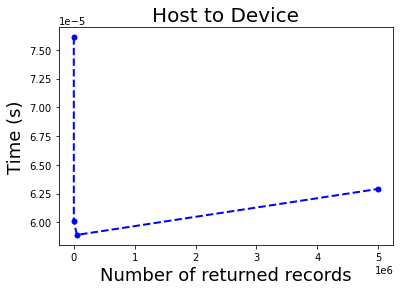

In [31]:
import matplotlib.pyplot as plt

plt.plot([5, 500, 50000, 5000000],[0.0000761, 0.0000601, 0.0000589, 0.0000629], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Number of returned records', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)